In [1]:
from time import perf_counter_ns
from random import random
from tqdm.notebook import tqdm
from decimal import Decimal, localcontext
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tracemalloc

In [2]:
sns.set(rc = {'figure.figsize':(14,6)})

# First experiment

In [29]:
def simple_matrix_prod(m1, m2):
    n = len(m1)
    result = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            result[i][j] = sum(m1[i][k] * m2[k][j] for k in range(n))    
    return result

def split_matrix(matrix):
    row, col = matrix.shape
    row2, col2 = row // 2, col // 2
    return matrix[:row2, :col2], matrix[:row2, col2:], matrix[row2:, :col2], matrix[row2:, col2:]

def join_matrix(m11, m12, m21, m22):
    ret = np.empty((len(m11) * 2, len(m11) * 2))
    ret[:len(m11), :len(m11)] = m11
    ret[:len(m11), len(m11):] = m12
    ret[len(m11):, :len(m11)] = m21
    ret[len(m11):, len(m11):] = m22
    return ret

def recursive_matrix_prod(a, b):
    if len(a) == 1:
        return a * b
    
    a11, a12, a21, a22 = split_matrix(a)
    b11, b12, b21, b22 = split_matrix(b)
    
    c11 = recursive_matrix_prod(a11, b11) + recursive_matrix_prod(a12, b21)
    c12 = recursive_matrix_prod(a11, b12) + recursive_matrix_prod(a12, b22)
    c21 = recursive_matrix_prod(a21, b11) + recursive_matrix_prod(a22, b21)
    c22 = recursive_matrix_prod(a21, b12) + recursive_matrix_prod(a22, b22)
    return join_matrix(c11, c12, c21, c22)
                                                                                    
def strassen_matrix_prod(a, b):
    if len(a) == 1:
        return a * b
    
    a11, a12, a21, a22 = split_matrix(a)
    b11, b12, b21, b22 = split_matrix(b)
    
    s1 = b12 - b22
    s2 = a11 + a12
    s3 = a21 + a22
    s4 = b21 - b11
    s5 = a11 + a22
    s6 = b11 + b22
    s7 = a12 - a22
    s8 = b21 + b22
    s9 = a11 - a21
    s10 = b11 - b12
 
    p1 = strassen_matrix_prod(a11, s1)
    p2 = strassen_matrix_prod(s2, b22) 
    p3 = strassen_matrix_prod(s3, b11)     
    p4 = strassen_matrix_prod(a22, s4)   
    p5 = strassen_matrix_prod(s5, s6)   
    p6 = strassen_matrix_prod(s7, s8) 
    p7 = strassen_matrix_prod(s9, s10)
 
    c11 = p5 + p4 - p2 + p6
    c12 = p1 + p2
    c21 = p3 + p4           
    c22 = p5 + p1 - p3 - p7 
 
    c = join_matrix(c11, c12, c21, c22)
    return c

def strassen_winograd_matrix_prod(a, b):
    if len(a) == 1:
        return a * b
    
    a11, a12, a21, a22 = split_matrix(a)
    b11, b12, b21, b22 = split_matrix(b)
    
    s1 = a21 + a22
    s2 = s1 - a11
    s3 = a11 - a21
    s4 = a12 - s2
    s5 = b12 - b11
    s6 = b22 - s5
    s7 = b22 - b12
    s8 = s6 - b21
 
    p1 = strassen_winograd_matrix_prod(s2, s6) 
    p2 = strassen_winograd_matrix_prod(a11, b11)       
    p3 = strassen_winograd_matrix_prod(a12, b21)       
    p4 = strassen_winograd_matrix_prod(s3, s7)       
    p5 = strassen_winograd_matrix_prod(s1, s5)       
    p6 = strassen_winograd_matrix_prod(s4, b22) 
    p7 = strassen_winograd_matrix_prod(a22, s8)
    
    t1 = p1 + p2
    t2 = t1 + p4
 
    c11 = p2 + p3 
    c12 = t1 + p5 + p6
    c21 = t2 - p7      
    c22 = t2 + p5
 
    c = join_matrix(c11, c12, c21, c22)
    return c

def measure_time_and_memory(f, args):
    tracemalloc.start()
    start = perf_counter_ns()
    f(*args)
    end = perf_counter_ns()
    memory = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    return end - start, memory

In [30]:
assert (strassen_matrix_prod(np.ones((4,4)), np.ones((4,4))) == strassen_winograd_matrix_prod(np.ones((4,4)), np.ones((4,4)))).all() and\
       (simple_matrix_prod(np.ones((4,4)), np.ones((4,4))) == recursive_matrix_prod(np.ones((4,4)), np.ones((4,4)))).all() and\
       (simple_matrix_prod(np.ones((4,4)), np.ones((4,4))) == strassen_matrix_prod(np.ones((4,4)), np.ones((4,4)))).all()

In [31]:
funcs = [simple_matrix_prod, recursive_matrix_prod, strassen_matrix_prod, strassen_winograd_matrix_prod]
reprs = ['SQUARE-MATRIX-MULTIPLY', 'SQUAREMATRIX-MULTIPLY-RECURSIVE', 'Strassen', 'Strassen-Winograd']
results = pd.DataFrame(columns=['Algorithm', 'Time', 'N', 'Memory'])
np.random.seed(40)
repeats = 3

for n_deg in tqdm(range(9)):
    n = 2 ** n_deg
    m1, m2 = (np.random.rand(n, n) for _ in range(2))
    for i, f in enumerate(funcs):
        time = memory = 0
        for _ in range(repeats):
            t, m = measure_time_and_memory(f, (m1, m2))
            time += t
            memory += m
        time /= repeats
        memory /= repeats
        results = results.append({'Algorithm': reprs[i], 'Time': time, 'N': n, 'Memory': memory}, ignore_index=True)

  0%|          | 0/9 [00:00<?, ?it/s]

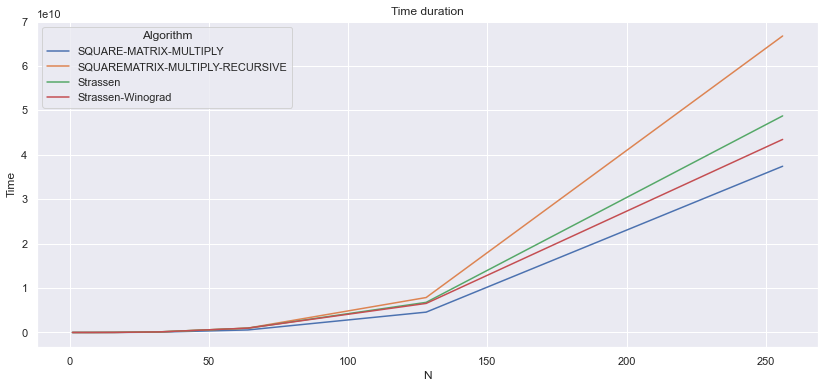

Text(0.5, 1.0, 'Memory consumption')

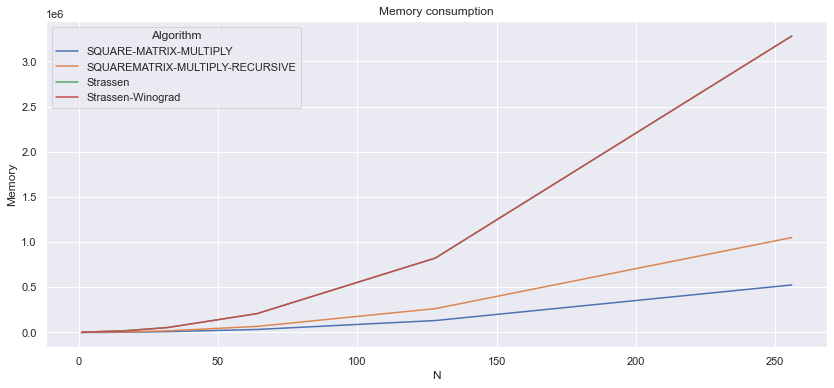

In [32]:
sns.lineplot(data=results, x='N', y='Time', hue='Algorithm')
plt.title('Time duration')
plt.show()
sns.lineplot(data=results, x='N', y='Memory', hue='Algorithm')
plt.title('Memory consumption')

# HYPERPARAMETERS TUNING

In [ ]:
def recursive_matrix_prod(a, b, minl):
    if len(a) <= minl:
        return simple_matrix_prod(a, b)
    
    a11, a12, a21, a22 = split_matrix(a)
    b11, b12, b21, b22 = split_matrix(b)
    
    c11 = recursive_matrix_prod(a11, b11, minl=minl) + recursive_matrix_prod(a12, b21, minl=minl)
    c12 = recursive_matrix_prod(a11, b12, minl=minl) + recursive_matrix_prod(a12, b22, minl=minl)
    c21 = recursive_matrix_prod(a21, b11, minl=minl) + recursive_matrix_prod(a22, b21, minl=minl)
    c22 = recursive_matrix_prod(a21, b12, minl=minl) + recursive_matrix_prod(a22, b22, minl=minl)
    return join_matrix(c11, c12, c21, c22)

def strassen_matrix_prod(a, b, minl):
    if len(a) <= minl:
        return simple_matrix_prod(a, b)
    
    a11, a12, a21, a22 = split_matrix(a)
    b11, b12, b21, b22 = split_matrix(b)
    
    s1 = b12 - b22
    s2 = a11 + a12
    s3 = a21 + a22
    s4 = b21 - b11
    s5 = a11 + a22
    s6 = b11 + b22
    s7 = a12 - a22
    s8 = b21 + b22
    s9 = a11 - a21
    s10 = b11 - b12
 
    p1 = strassen_matrix_prod(a11, s1, minl=minl)
    p2 = strassen_matrix_prod(s2, b22, minl=minl) 
    p3 = strassen_matrix_prod(s3, b11, minl=minl)     
    p4 = strassen_matrix_prod(a22, s4, minl=minl)   
    p5 = strassen_matrix_prod(s5, s6, minl=minl)   
    p6 = strassen_matrix_prod(s7, s8, minl=minl) 
    p7 = strassen_matrix_prod(s9, s10, minl=minl)
 
    c11 = p5 + p4 - p2 + p6
    c12 = p1 + p2
    c21 = p3 + p4           
    c22 = p5 + p1 - p3 - p7 
 
    c = join_matrix(c11, c12, c21, c22)
    return c

def strassen_winograd_matrix_prod(a, b, minl):
    if len(a) <= minl:
        return simple_matrix_prod(a, b)
    
    a11, a12, a21, a22 = split_matrix(a)
    b11, b12, b21, b22 = split_matrix(b)
    
    s1 = a21 + a22
    s2 = s1 - a11
    s3 = a11 - a21
    s4 = a12 - s2
    s5 = b12 - b11
    s6 = b22 - s5
    s7 = b22 - b12
    s8 = s6 - b21
 
    p1 = strassen_winograd_matrix_prod(s2, s6, minl=minl) 
    p2 = strassen_winograd_matrix_prod(a11, b11, minl=minl)       
    p3 = strassen_winograd_matrix_prod(a12, b21, minl=minl)       
    p4 = strassen_winograd_matrix_prod(s3, s7, minl=minl)       
    p5 = strassen_winograd_matrix_prod(s1, s5, minl=minl)       
    p6 = strassen_winograd_matrix_prod(s4, b22, minl=minl) 
    p7 = strassen_winograd_matrix_prod(a22, s8, minl=minl)
    
    t1 = p1 + p2
    t2 = t1 + p4
 
    c11 = p2 + p3 
    c12 = t1 + p5 + p6
    c21 = t2 - p7      
    c22 = t2 + p5
 
    c = join_matrix(c11, c12, c21, c22)
    return c

In [ ]:
times = pd.DataFrame(columns=['Threshold', 'Time', 'N'])
np.random.seed(40)
for i in tqdm(range(9)):
    n = 2 ** i
    m1, m2 = (np.random.rand(n, n) for _ in range(2))
    for j in range(8, 16):
        time, memory = measure_time_and_memory(strassen_matrix_prod, (m1, m2, j))
        times = times.append({'Threshold': j, 'Time': time, 'N': n}, ignore_index=True)

In [ ]:
sns.lineplot(data=times, x='N', y='Time', hue='Threshold')

In [ ]:
for threshold in range(9, 16):
    plt.plot([2 ** i for i in range(9)], [times[(times.N == 2 ** i) & (times.Threshold == threshold)].iloc[0].Time - \
                                          times[(times.N == 2 ** i) & (times.Threshold == 8)].iloc[0].Time  for i in range(9)],\
            label=f'Th_{threshold}')
    plt.xlabel('N')
    plt.ylabel('Time difference')
    plt.legend()

In [ ]:
results[(results.Algorithm == repr[0])]

In [ ]:
times.groupby('Threshold').mean().sort_values('Time')['Time'].iloc[:3]

In [ ]:
times = pd.DataFrame(columns=['Threshold', 'Time', 'N'])
np.random.seed(40)

for i in tqdm(range(9)):
    n = 2 ** i
    m1, m2 = (np.random.rand(n, n) for _ in range(2))
    for j in range(8, 16):
        time, memory = measure_time_and_memory(strassen_winograd_matrix_prod, (m1, m2, j))
        times = times.append({'Threshold': j, 'Time': time, 'N': n}, ignore_index=True)
        
print(times.groupby('Threshold').mean().sort_values('Time')['Time'].iloc[:3])

for threshold in range(9, 16):
    plt.plot([2 ** i for i in range(9)], [times[(times.N == 2 ** i) & (times.Threshold == threshold)].iloc[0].Time - \
                                          times[(times.N == 2 ** i) & (times.Threshold == 8)].iloc[0].Time  for i in range(9)],\
            label=f'Th_{threshold + 1}')
plt.xlabel('N')
plt.ylabel('Time difference')
plt.legend()

In [ ]:
times = pd.DataFrame(columns=['Threshold', 'Time', 'N'])
np.random.seed(40)

for i in tqdm(range(9)):
    n = 2 ** i
    m1, m2 = (np.random.rand(n, n) for _ in range(2))
    for j in range(8, 16):
        time, memory = measure_time_and_memory(recursive_matrix_prod, (m1, m2, j))
        times = times.append({'Threshold': j, 'Time': time, 'N': n}, ignore_index=True)
        
print(times.groupby('Threshold').mean().sort_values('Time')['Time'].iloc[:3])

for threshold in range(9, 16):
    plt.plot([2 ** i for i in range(9)], [times[(times.N == 2 ** i) & (times.Threshold == threshold)].iloc[0].Time - \
                                          times[(times.N == 2 ** i) & (times.Threshold == 8)].iloc[0].Time  for i in range(9)],\
            label=f'Th_{threshold + 1}')
plt.xlabel('N')
plt.ylabel('Time difference')
plt.legend()
plt.title(reprs[1])

# Second experiment

In [15]:
def recursive_matrix_prod(a, b, minl=10):
    if len(a) <= minl:
        return simple_matrix_prod(a, b)
    
    a11, a12, a21, a22 = split_matrix(a)
    b11, b12, b21, b22 = split_matrix(b)
    
    c11 = recursive_matrix_prod(a11, b11, minl=minl) + recursive_matrix_prod(a12, b21, minl=minl)
    c12 = recursive_matrix_prod(a11, b12, minl=minl) + recursive_matrix_prod(a12, b22, minl=minl)
    c21 = recursive_matrix_prod(a21, b11, minl=minl) + recursive_matrix_prod(a22, b21, minl=minl)
    c22 = recursive_matrix_prod(a21, b12, minl=minl) + recursive_matrix_prod(a22, b22, minl=minl)
    return join_matrix(c11, c12, c21, c22)

def strassen_matrix_prod(a, b, minl=10):
    if len(a) <= minl:
        return simple_matrix_prod(a, b)
    
    a11, a12, a21, a22 = split_matrix(a)
    b11, b12, b21, b22 = split_matrix(b)
    
    s1 = b12 - b22
    s2 = a11 + a12
    s3 = a21 + a22
    s4 = b21 - b11
    s5 = a11 + a22
    s6 = b11 + b22
    s7 = a12 - a22
    s8 = b21 + b22
    s9 = a11 - a21
    s10 = b11 - b12
 
    p1 = strassen_matrix_prod(a11, s1, minl=minl)
    p2 = strassen_matrix_prod(s2, b22, minl=minl) 
    p3 = strassen_matrix_prod(s3, b11, minl=minl)     
    p4 = strassen_matrix_prod(a22, s4, minl=minl)   
    p5 = strassen_matrix_prod(s5, s6, minl=minl)   
    p6 = strassen_matrix_prod(s7, s8, minl=minl) 
    p7 = strassen_matrix_prod(s9, s10, minl=minl)
 
    c11 = p5 + p4 - p2 + p6
    c12 = p1 + p2
    c21 = p3 + p4           
    c22 = p5 + p1 - p3 - p7 
 
    c = join_matrix(c11, c12, c21, c22)
    return c

def strassen_winograd_matrix_prod(a, b, minl=10):
    if len(a) <= minl:
        return simple_matrix_prod(a, b)
    
    a11, a12, a21, a22 = split_matrix(a)
    b11, b12, b21, b22 = split_matrix(b)
    
    s1 = a21 + a22
    s2 = s1 - a11
    s3 = a11 - a21
    s4 = a12 - s2
    s5 = b12 - b11
    s6 = b22 - s5
    s7 = b22 - b12
    s8 = s6 - b21
 
    p1 = strassen_winograd_matrix_prod(s2, s6, minl=minl) 
    p2 = strassen_winograd_matrix_prod(a11, b11, minl=minl)       
    p3 = strassen_winograd_matrix_prod(a12, b21, minl=minl)       
    p4 = strassen_winograd_matrix_prod(s3, s7, minl=minl)       
    p5 = strassen_winograd_matrix_prod(s1, s5, minl=minl)       
    p6 = strassen_winograd_matrix_prod(s4, b22, minl=minl) 
    p7 = strassen_winograd_matrix_prod(a22, s8, minl=minl)
    
    t1 = p1 + p2
    t2 = t1 + p4
 
    c11 = p2 + p3 
    c12 = t1 + p5 + p6
    c21 = t2 - p7      
    c22 = t2 + p5
 
    c = join_matrix(c11, c12, c21, c22)
    return c

In [25]:
results2 = pd.DataFrame(columns=['Algorithm', 'Time', 'N', 'Memory'])
np.random.seed(40)

for n_deg in tqdm(range(9)):
    n = 2 ** n_deg
    m1, m2 = (np.random.rand(n, n) for _ in range(2))
    for i, f in enumerate(funcs):
        time = memory = 0
        for _ in range(repeats):
            t, m = measure_time_and_memory(f, (m1, m2))
            time += t
            memory += m
        time /= repeats
        memory /= repeats
        
        results2 = results2.append({'Algorithm': reprs[i], 'Time': time, 'N': n, 'Memory': memory}, ignore_index=True)

  0%|          | 0/9 [00:00<?, ?it/s]

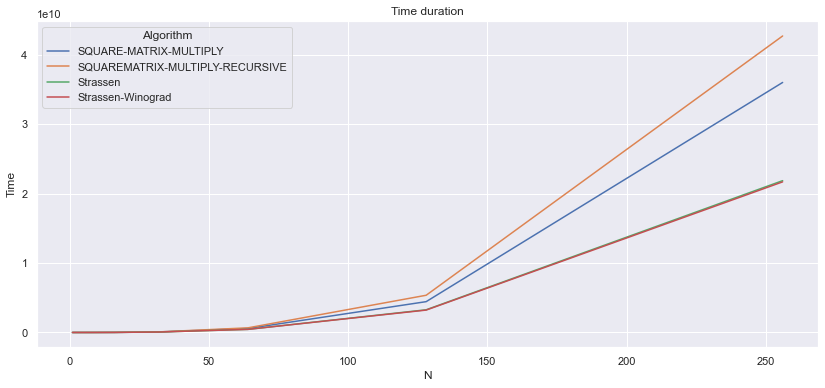

Text(0.5, 1.0, 'Memory consumption')

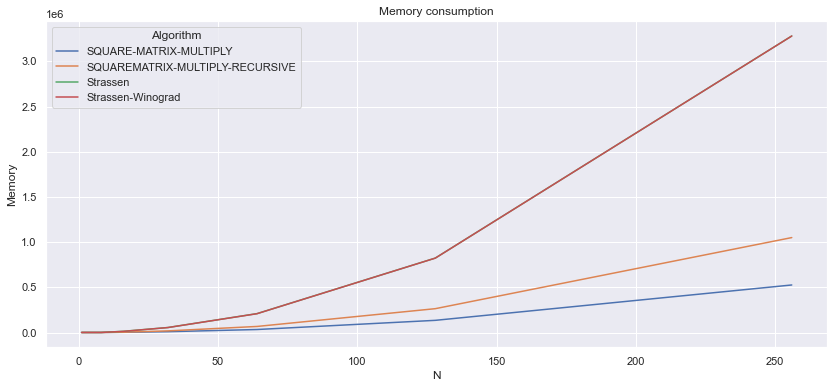

In [26]:
sns.lineplot(data=results2, x='N', y='Time', hue='Algorithm')
plt.title('Time duration')
plt.show()
sns.lineplot(data=results2, x='N', y='Memory', hue='Algorithm')
plt.title('Memory consumption')

In [27]:
results2

,Algorithm,Time,N,Memory
0,SQUARE-MATRIX-MULTIPLY,1.636667e+04,1,6.266667e+02
1,SQUAREMATRIX-MULTIPLY-RECURSIVE,2.560000e+04,1,6.240000e+02
2,Strassen,1.633333e+04,1,6.240000e+02
3,Strassen-Winograd,1.466667e+04,1,6.240000e+02
4,SQUARE-MATRIX-MULTIPLY,3.600000e+04,2,6.480000e+02
5,SQUAREMATRIX-MULTIPLY-RECURSIVE,3.740000e+04,2,6.480000e+02
6,Strassen,3.750000e+04,2,6.480000e+02
7,Strassen-Winograd,3.780000e+04,2,6.480000e+02
8,SQUARE-MATRIX-MULTIPLY,1.901333e+05,4,6.480000e+02
9,SQUAREMATRIX-MULTIPLY-RECURSIVE,1.868333e+05,4,6.480000e+02


In [33]:
results

,Algorithm,Time,N,Memory
0,SQUARE-MATRIX-MULTIPLY,1.713333e+04,1,6.266667e+02
1,SQUAREMATRIX-MULTIPLY-RECURSIVE,6.233333e+03,1,1.200000e+02
2,Strassen,4.566667e+03,1,1.200000e+02
3,Strassen-Winograd,4.300000e+03,1,1.200000e+02
4,SQUARE-MATRIX-MULTIPLY,3.760000e+04,2,6.480000e+02
5,SQUAREMATRIX-MULTIPLY-RECURSIVE,4.030000e+04,2,1.600000e+03
6,Strassen,6.386667e+04,2,3.986667e+03
7,Strassen-Winograd,7.153333e+04,2,3.997333e+03
8,SQUARE-MATRIX-MULTIPLY,1.865667e+05,4,6.480000e+02
9,SQUAREMATRIX-MULTIPLY-RECURSIVE,3.034667e+05,4,3.040000e+03
